In [1]:
import numpy as np
import cv2
from pyproj import Transformer
from my_vbr_utils.vbr_dataset import vbrInterpolatedDataset, load_calibration, get_paths_from_scene
from my_vbr_utils.utilities import load_scene_correspondences

# --- Config and Dataset Loading ---
# Set these variables to configure your scene and utility path
scene_name = 'spagna_train0'
dataset_root_dir = "/datasets/vbr_slam"
calib_path = get_paths_from_scene(dataset_root_dir, scene_name)[-1]
calib = load_calibration(calib_path)

dataset = vbrInterpolatedDataset(dataset_root_dir,scene_name)




Loaded vbrInterpolatedDataset from scene:  spagna_train0
Images loaded from:  /datasets/vbr_slam/spagna/spagna_train0_kitti/camera_left/data
Ground Truth Poses:  /datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt


In [2]:
### LOAD MAST3R MODEL AND INFERENCE UTILITIES
from mast3r.model import AsymmetricMASt3R
#load model
device = 'cuda:4'
model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
# print(model)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_pair(anchor_img, query_img, anchor_idx=None, query_idx=None, figsize=(12, 6), titles=None):
    """
    Display anchor and query images side by side.
    """
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(query_img)
    title = f'Query {query_idx}' if query_idx is not None else 'Query'
    if titles and len(titles) > 0:
        title = titles[0]
    plt.title(title)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(anchor_img)
    title = f'Anchor {anchor_idx}' if anchor_idx is not None else 'Anchor'
    if titles and len(titles) > 1:
        title = titles[1]
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()



def plot_pointclouds_top_view(pointclouds, labels=None, colors=None, s=10, alpha=0.5, title=None, ax=None):
    """
    Plot multiple point clouds in top-down (X-Z) view.
    pointclouds: list of (N,3) arrays
    labels: list of strings
    colors: list of colors
    """
    if not isinstance(pointclouds, list):
        pointclouds = [pointclouds]
    if labels is None:
        labels = [f"Cloud {i}" for i in range(len(pointclouds))]
    if colors is None:
        colors = ['blue', 'orange', 'green', 'red', 'purple']
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    for i, pts in enumerate(pointclouds):
        if pts is not None and pts.size > 0:
            ax.scatter(pts[:, 0], pts[:, 2], c=colors[i % len(colors)], s=s, marker='o', alpha=alpha, label=labels[i])
    ax.set_xlabel('X (Right)')
    ax.set_ylabel('Z (Forward)')
    ax.set_title(title if title else 'Top-View of Point Clouds')
    ax.axis('equal')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


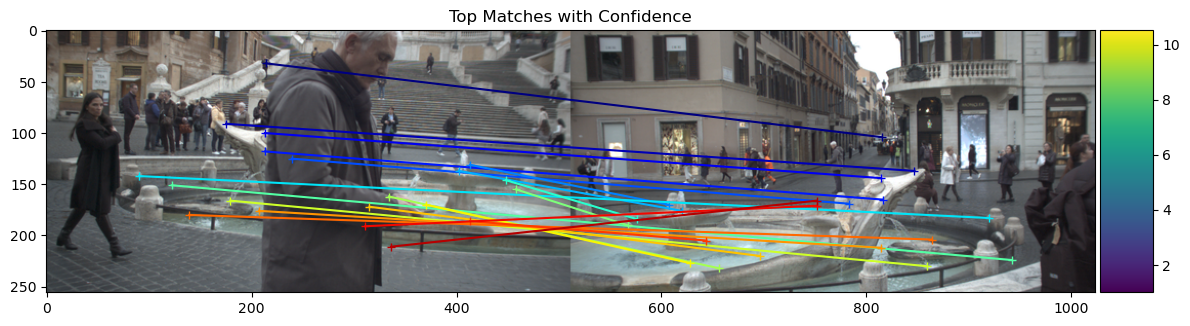

Fundamental matrix: 380 matches, 223 inliers, 157 outliers
Mast3r image shape:  256 512


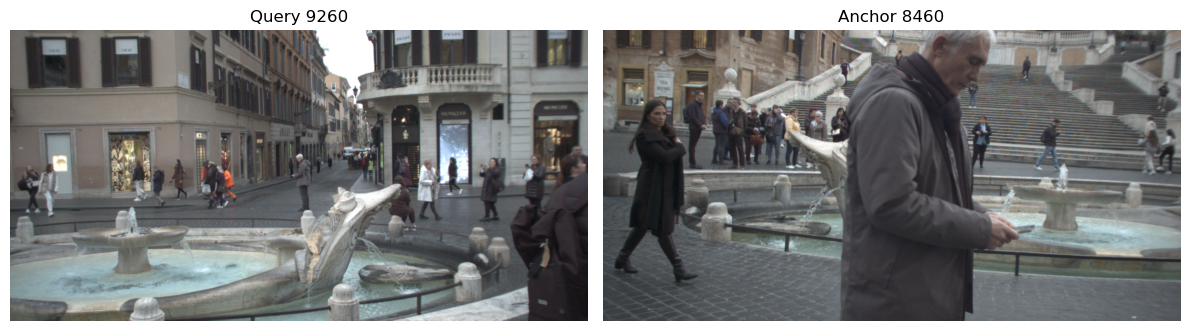

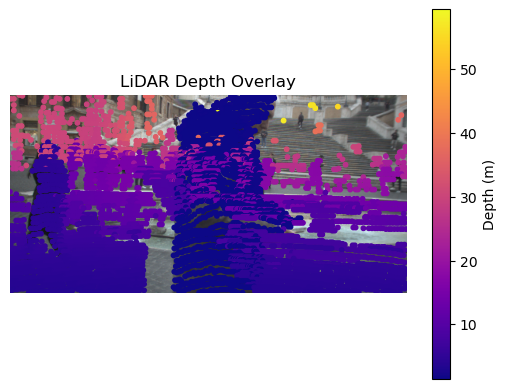

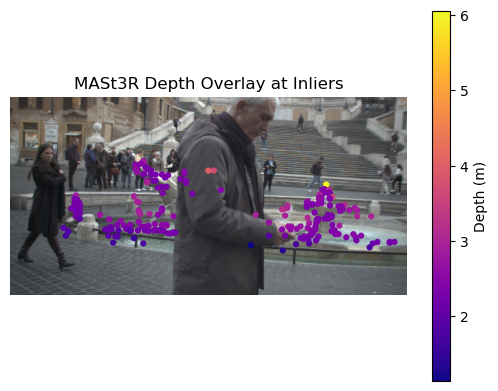

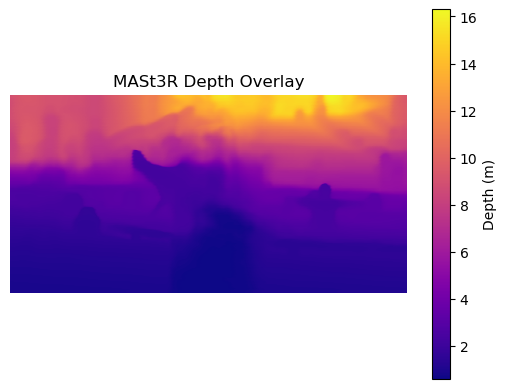

Recovered 104 matches with depth
Number of inlier matches: 104


In [4]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from scipy.spatial.transform import Rotation as Rscipy
from my_utils.mast3r_utils import get_master_output, get_mast3r_image_shape,scale_intrinsics,overlap,plot_depth_overlay_on_image,plot_lidar_mast3r_matches
from my_utils.my_vbr_dataset import generate_depth_and_scene_maps

# --- Load anchor-query pair ---
# pairs_df = pd.read_csv('/home/bjangley/VPR/mast3r-v2/results2/spagna_matches_inliers_fm_top3.csv')
# anchor_idx, query_idx = int(row['anchor_idx']), int(row['query_idx'])
# anchor_idx, query_idx =  4550, 16548
anchor_idx, query_idx = 8460, 9260
# anchor_idx, query_idx = 8460, 23348
# anchor_idx, query_idx = 10150, 20108
# anchor_idx, query_idx = 6970, 18488     
# anchor_idx, query_idx = 10030, 19968
# anchor_idx, query_idx = 0, 23088
anchor = dataset[anchor_idx]
query  = dataset[query_idx]
gt_pose = query['pose']

# --- Run MASt3R model and extract matches ---
output = get_master_output(
    model, device,
    anchor['image'],
    query['image'],
    visualize=True,
    verbose=False
)
matches_im0 = output[0]
matches_im1 = output[1]
pts3d_im0   = output[2]


# --- find number of inliers from the matches ---
if len(matches_im0) >= 8:
    F, mask_f = cv2.findFundamentalMat(matches_im0, matches_im1, cv2.FM_RANSAC, 1, 0.99)
    num_inliers_f = int(mask_f.sum()) if mask_f is not None else 0
    inlier_mask = mask_f.ravel().astype(bool)
    inlier_im0 = matches_im0[inlier_mask]
    inlier_im1 = matches_im1[inlier_mask]
else:
    num_inliers_f = 0
    inlier_im0 = np.empty((0, 2))
    inlier_im1 = np.empty((0, 2))
print(f"Fundamental matrix: {len(matches_im0)} matches, {num_inliers_f} inliers, {len(matches_im0) - num_inliers_f} outliers")


T_cam_lidar = calib['cam_l']['T_cam_lidar']
K = calib['cam_l']['K']
# --- LiDAR projection and image resizing ---
img = cv2.imread(anchor['image'])
H, W = img.shape[:2]
mast3r_w, mast3r_h = get_mast3r_image_shape(W, H)
print("Mast3r image shape: ", mast3r_h, mast3r_w)
K_new = scale_intrinsics(K, W, H, mast3r_w, mast3r_h)
depth_map, scene_map = generate_depth_and_scene_maps(anchor['lidar_points'], K_new, T_cam_lidar, (mast3r_h, mast3r_w))

# --- Load and show anchor/query images ---
anchor_img = Image.open(anchor['image'])
query_img = Image.open(query['image'])
show_image_pair(anchor_img, query_img, anchor_idx, query_idx)

# --- LiDAR depth overlay ---
img_orig = plt.imread(anchor['image'])
img_resized = cv2.resize(img_orig, (mast3r_w, mast3r_h))
img_resized = img_resized.astype(np.float32) / 255.0 if img_resized.dtype == np.uint8 else img_resized
v, u = np.where(np.isfinite(depth_map))
pixel_uv = np.stack((u, v), axis=-1)
plot_depth_overlay_on_image(img_resized, scene_map, pixel_uv, point_size=10, alpha=1.0, title="LiDAR Depth Overlay")

# # --- MASt3R 3D points overlay ---
# if len(matches_im0) > 0:
#     plot_depth_overlay_on_image(
#         img_resized,
#         pts3d_im0,
#         matches_im0,
#         point_size=12,
#         cmap='plasma',
#         alpha=1.0,
#         title="MASt3R Depth Overlay on all Matches"
#     )
if num_inliers_f > 0:
    plot_depth_overlay_on_image(
        img_resized,
        pts3d_im0,
        inlier_im0,
        point_size=12,
        cmap='plasma',
        alpha=1.0,
        title="MASt3R Depth Overlay at Inliers"
    )


H, W, _ = pts3d_im0.shape 
u_grid, v_grid = np.meshgrid(np.arange(W), np.arange(H)) #mast3r image shape
all_uv = np.stack([u_grid.ravel(), v_grid.ravel()], axis=-1)  # shape (H*W, 2)
if num_inliers_f > 0:
    plot_depth_overlay_on_image(
        img_resized,
        pts3d_im0,
        all_uv,
        point_size=12,
        cmap='plasma',
        alpha=1.0,
        title="MASt3R Depth Overlay"
    )

# --- Overlap between inlier keypoints and LiDAR depth map ---

matched_uv, matched_lidar_uv, matched_indices = overlap(inlier_im0, depth_map, max_pixel_dist=2)
inlier_im0 = inlier_im0[matched_indices]
inlier_im1 = inlier_im1[matched_indices]
print(f"Recovered {len(matched_uv)} matches with depth")
print(f"Number of inlier matches: {len(inlier_im0)}")


# # --- Plot top-down view of point clouds ---
# plot_pointclouds_top_view(
#     [lidar_pts, master_pts, master_pts_scaled],
#     labels=['LiDAR', 'MASt3R', 'Scaled MASt3R'],
#     colors=['blue', 'orange', 'green'],
#     title='Top-Down View: Matched LiDAR and MASt3R Points'
# )

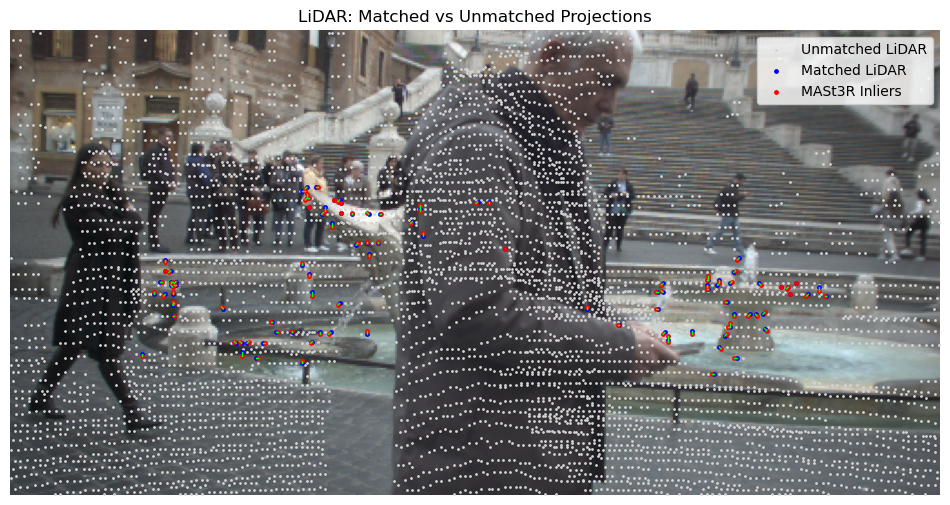

In [5]:
def plot_lidar_mast3r_matches(img, lidar_uv, matched_lidar_uv, inliers_im0, title="LiDAR: Matched vs Unmatched Projections"):
    """
    Visualize matched/unmatched LiDAR projections and MASt3R inlier matches.

    Args:
        img: Image array (background for scatter plot)
        lidar_uv: (N,2) array of all valid LiDAR-projected pixel coordinates
        matched_lidar_uv: (M,2) array of matched LiDAR pixel coordinates
        inliers_im0: (M,2) array of MASt3R inlier keypoints
          (matched to LiDAR)
        title: Plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np

    matched_lidar_uv_set = set(map(tuple, matched_lidar_uv))
    mask_matched = np.array([tuple(uv) in matched_lidar_uv_set for uv in lidar_uv])
    lidar_matched_uv = lidar_uv[mask_matched]
    lidar_unmatched_uv = lidar_uv[~mask_matched]
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    if len(lidar_unmatched_uv) > 0:
        plt.scatter(lidar_unmatched_uv[:, 0], lidar_unmatched_uv[:, 1], c='lightgray', s=1, label='Unmatched LiDAR')
    if len(lidar_matched_uv) > 0:
        plt.scatter(lidar_matched_uv[:, 0], lidar_matched_uv[:, 1], c='blue', s=6, label='Matched LiDAR')
    if len(inliers_im0) > 0:
        plt.scatter(inliers_im0[:, 0], inliers_im0[:, 1], c='red', s=6, label='MASt3R Inliers')
        # Draw lines between inlier keypoints and matched LiDAR
        for match_uv, lidar_uv_ in zip(inliers_im0, matched_lidar_uv):
            plt.plot([match_uv[0], lidar_uv_[0]], [match_uv[1], lidar_uv_[1]], color='lime', linewidth=1)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()


# Prepare lidar_uv as before
v_all, u_all = np.where(np.isfinite(depth_map))
lidar_uv = np.stack((u_all, v_all), axis=-1)

plot_lidar_mast3r_matches(
    img_resized,
    lidar_uv,
    matched_lidar_uv,
    inlier_im0
)

Scale estimated for v3 (L1 centroid scale): 4.12017176629801
Scale estimated for v4 (per-axis L1 scale): [3.5656874 3.503793  4.0410566]
Scale estimated for ICP (Umeyama): 3.223785140264951


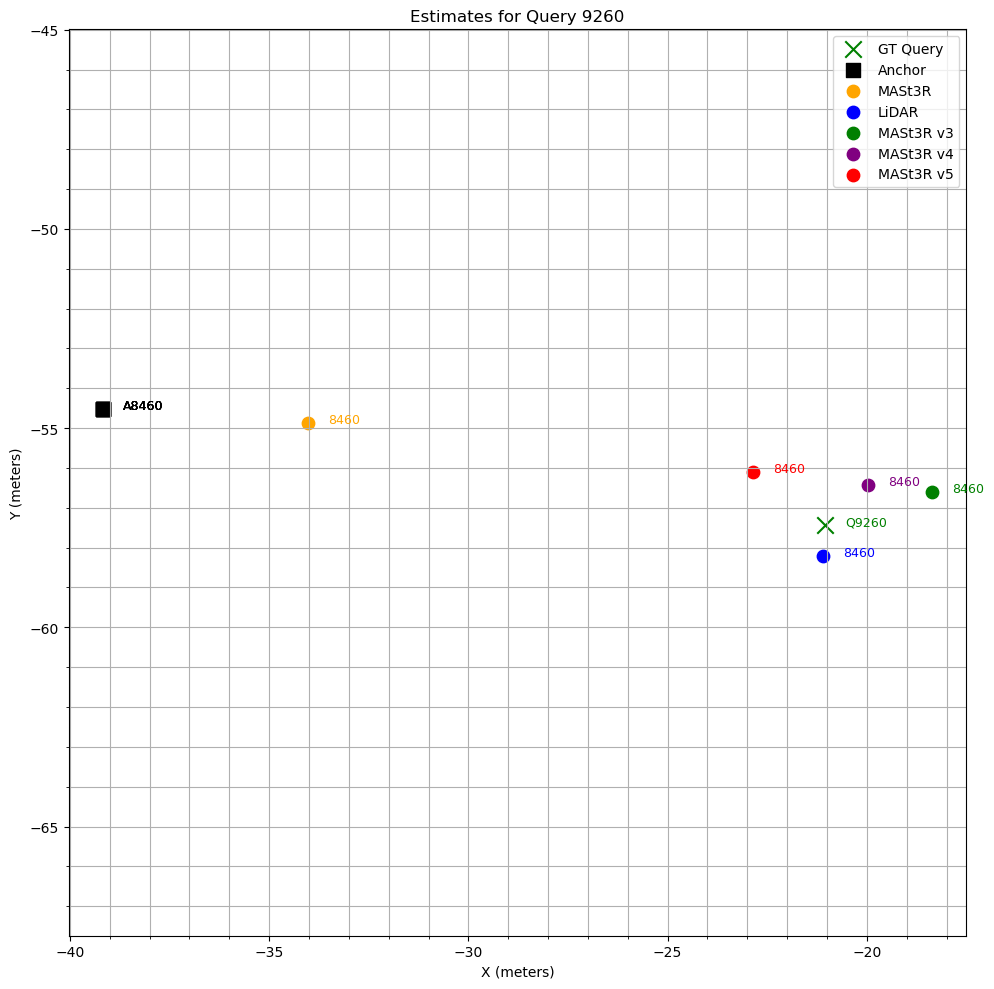

In [6]:
# Compute all localizations for the loaded anchor-query pair

from my_utils.scaling import compute_scaled_points
from my_utils.transformations import se3_to_pose, pose_to_se3
from my_utils.mast3r_utils import solve_pnp

T_base_cam = calib['cam_l']['T_base_cam']

# --- Prepare inlier 3D-2D correspondences ---
if len(inlier_im0) >= 4:
    mast3r_pts = pts3d_im0[inlier_im0[:, 1].astype(int), inlier_im0[:, 0].astype(int)]
    lidar_pts = scene_map[matched_lidar_uv[:, 1].astype(int), matched_lidar_uv[:, 0].astype(int)]
    inlier_2d = inlier_im1.astype(np.float32)
else:
    mast3r_pts = np.empty((0, 3))
    lidar_pts = np.empty((0, 3))
    inlier_2d = np.empty((0, 2))

T_anchor_local = pose_to_se3(anchor['pose'])

# --- PnP from MASt3R ---
T_query_anchor_mast3r = solve_pnp(mast3r_pts, inlier_2d, K_new) if len(mast3r_pts) >= 4 else None
if T_query_anchor_mast3r is not None:
    T_m_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_mast3r)
    pose_m = se3_to_pose(T_m_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- PnP from LiDAR ---
T_query_anchor_lidar = solve_pnp(lidar_pts, inlier_2d, K_new) if len(lidar_pts) >= 4 else None
if T_query_anchor_lidar is not None:
    T_l_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_lidar)
    pose_l = se3_to_pose(T_l_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled v3 (L1 centroid scale) ---
mast3r_pts_scaled_v3, scale_v3 = compute_scaled_points('v3', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v3 is not None:
    print(f"Scale estimated for v3 (L1 centroid scale): {scale_v3}")
T_query_anchor_scaled_v3 = solve_pnp(mast3r_pts_scaled_v3, inlier_2d, K_new) if mast3r_pts_scaled_v3.size > 0 else None
if T_query_anchor_scaled_v3 is not None:
    T_s3_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_v3)
    pose_s3 = se3_to_pose(T_s3_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled v4 (per-axis L1 scale) ---
mast3r_pts_scaled_v4, scale_v4 = compute_scaled_points('v4', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_v4 is not None:
    print(f"Scale estimated for v4 (per-axis L1 scale): {scale_v4}")
T_query_anchor_scaled_v4 = solve_pnp(mast3r_pts_scaled_v4, inlier_2d, K_new) if mast3r_pts_scaled_v4.size > 0 else None
if T_query_anchor_scaled_v4 is not None:
    T_s4_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_v4)
    pose_s4 = se3_to_pose(T_s4_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- MASt3R scaled ICP (Umeyama) ---
mast3r_pts_scaled_icp, scale_icp = compute_scaled_points('icp', mast3r_pts, lidar_pts) if len(mast3r_pts) >= 4 and len(lidar_pts) >= 4 else (np.empty((0, 3)), None)
if scale_icp is not None:
    print(f"Scale estimated for ICP (Umeyama): {scale_icp}")
T_query_anchor_scaled_icp = solve_pnp(mast3r_pts_scaled_icp, inlier_2d, K_new) if mast3r_pts_scaled_icp.size > 0 else None
if T_query_anchor_scaled_icp is not None:
    T_icp_local = T_anchor_local @ T_base_cam @ np.linalg.inv(T_query_anchor_scaled_icp)
    pose_icp = se3_to_pose(T_icp_local)  # Convert to [tx, ty, tz, qx, qy, qz, qw]

# --- Plot all estimates ---
from my_utils.plotting import plot_all_estimates_for_query

results_dicts = {}
if 'pose_m' in locals() and pose_m is not None:
    results_dicts['MASt3R'] = ({query_idx: [(anchor_idx, pose_m)]}, {'anchor': 'black', 'estimate': 'orange'})
if 'pose_l' in locals() and pose_l is not None:
    results_dicts['LiDAR'] = ({query_idx: [(anchor_idx, pose_l)]}, {'anchor': 'black', 'estimate': 'blue'})
if 'pose_s3' in locals() and pose_s3 is not None:
    results_dicts['MASt3R v3'] = ({query_idx: [(anchor_idx, pose_s3)]}, {'anchor': 'black', 'estimate': 'green'})
if 'pose_s4' in locals() and pose_s4 is not None:
    results_dicts['MASt3R v4'] = ({query_idx: [(anchor_idx, pose_s4)]}, {'anchor': 'black', 'estimate': 'purple'})
if 'pose_icp' in locals() and pose_icp is not None:
    results_dicts['MASt3R v5'] = ({query_idx: [(anchor_idx, pose_icp)]}, {'anchor': 'black', 'estimate': 'red'})

plot_all_estimates_for_query(query_idx, dataset, results_dicts, styles=None)

In [7]:
print(T_query_anchor_scaled_v3)
# Compute ground truth pose
T_local_anchor = pose_to_se3(anchor['pose'])
T_local_query = pose_to_se3(query['pose'])
T_query_anchor_gt = np.linalg.inv(T_local_query @ T_base_cam) @ T_local_anchor @ T_base_cam
print(T_query_anchor_gt)

[[-9.90834561e-01 -1.94266501e-02 -1.33676767e-01  1.75200803e+00]
 [-3.23577250e-02  9.94927098e-01  9.52525397e-02  1.37517118e-01]
 [ 1.31148200e-01  9.87049844e-02 -9.86436757e-01  2.09528850e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.99739316e-01 -1.02661984e-02 -2.03938085e-02  8.58784257e-01]
 [-1.24397306e-02  9.93910071e-01  1.09489805e-01 -1.48570331e-01]
 [ 1.91455754e-02  1.09715005e-01 -9.93778682e-01  1.84762707e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


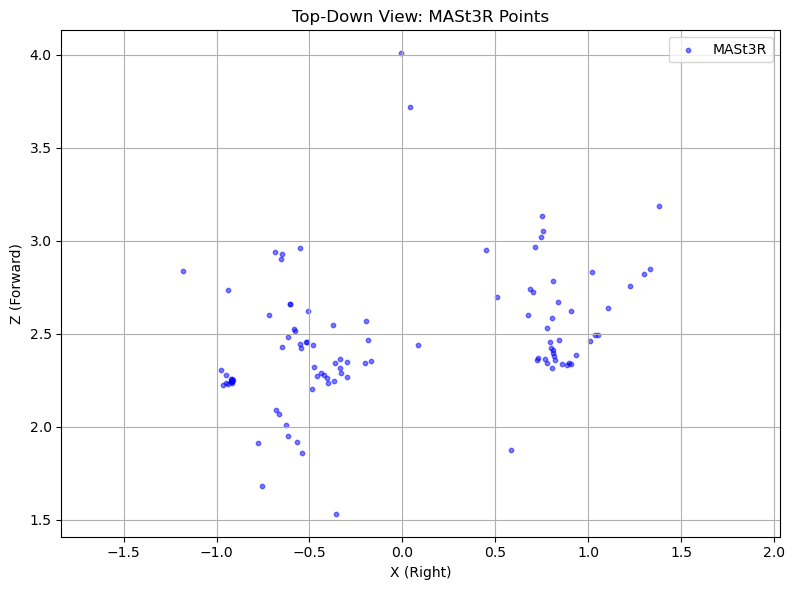

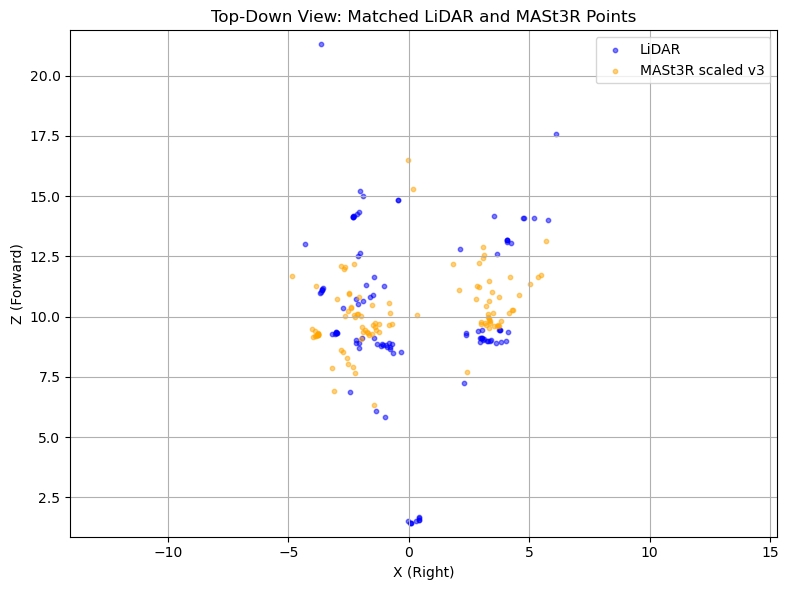

In [8]:
# --- Plot top-down view of point clouds ---
# plot_pointclouds_top_view(
#     [lidar_pts, mast3r_pts, mast3r_pts_scaled_v3, mast3r_pts_scaled_v4, mast3r_pts_scaled_icp],
#     labels=['LiDAR', 'MASt3R', 'Scaled MASt3R v3', 'Scaled MASt3R v4', 'Scaled MASt3R v5'],
#     colors=['blue', 'orange', 'green', 'purple', 'red'],
#     title='Top-Down View: Matched LiDAR and MASt3R Points'
# )

# # --- Plot top-down view of point clouds ---
# plot_pointclouds_top_view(
#     [lidar_pts],
#     labels=['LiDAR'],
#     colors=['blue'],
#     title='Top-Down View: LiDAR'
# )

plot_pointclouds_top_view(
    [ mast3r_pts],
    labels=['MASt3R'],
    colors=['blue'],
    title='Top-Down View: MASt3R Points'
)

plot_pointclouds_top_view(
    [lidar_pts, mast3r_pts_scaled_v3],
    labels=['LiDAR', 'MASt3R scaled v3'],
    colors=['blue', 'orange'],
    title='Top-Down View: Matched LiDAR and MASt3R Points'
)

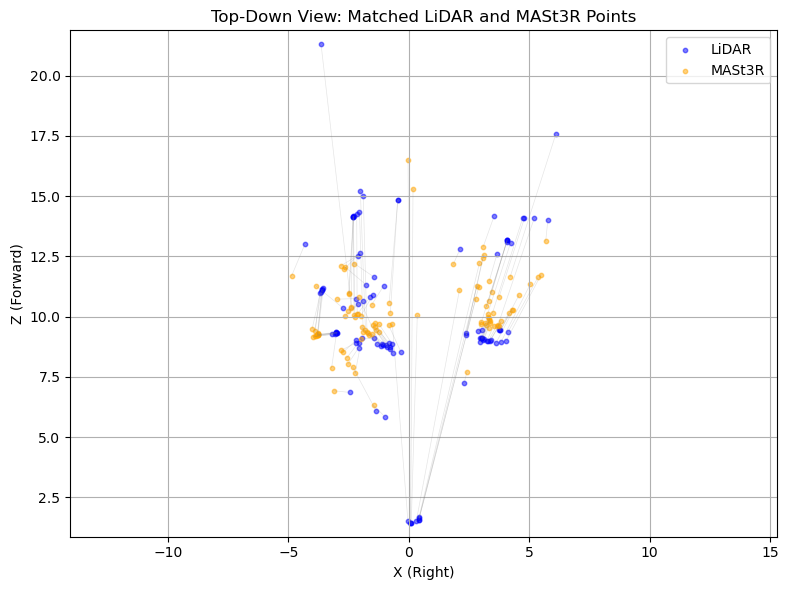

In [9]:

def plot_pointclouds_top_view2(pointclouds, labels=None, colors=None, s=10, alpha=0.5, title=None, ax=None, correspondences=None):
    """
    Plot multiple point clouds in top-down (X-Z) view, with optional correspondences.

    Args:
        pointclouds: list of (N,3) arrays
        labels: list of strings
        colors: list of colors
        s: marker size
        alpha: transparency
        title: plot title
        ax: matplotlib axes object
        correspondences: list of (N,2) arrays, where each array contains indices
                       into pointclouds[0] and pointclouds[1] that are corresponding.
    """
    if not isinstance(pointclouds, list):
        pointclouds = [pointclouds]
    if labels is None:
        labels = [f"Cloud {i}" for i in range(len(pointclouds))]
    if colors is None:
        colors = ['blue', 'orange', 'green', 'red', 'purple']
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    for i, pts in enumerate(pointclouds):
        if pts is not None and pts.size > 0:
            ax.scatter(pts[:, 0], pts[:, 2], c=colors[i % len(colors)], s=s, marker='o', alpha=alpha, label=labels[i])

    # Plot correspondences if provided
    if correspondences is not None and len(pointclouds) >= 2:
        pts0 = pointclouds[0]
        pts1 = pointclouds[1]
        if pts0 is not None and pts1 is not None and pts0.size > 0 and pts1.size > 0:
            for i, j in correspondences:
                ax.plot([pts0[i, 0], pts1[j, 0]], [pts0[i, 2], pts1[j, 2]], c='gray', linewidth=0.5, alpha=0.2)

    ax.set_xlabel('X (Right)')
    ax.set_ylabel('Z (Forward)')
    ax.set_title(title if title else 'Top-View of Point Clouds')
    ax.axis('equal')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# Create correspondence indices
correspondences = np.column_stack([np.arange(len(lidar_pts)), np.arange(len(mast3r_pts))]).tolist()

plot_pointclouds_top_view2(
    [lidar_pts, mast3r_pts_scaled_v3],
    labels=['LiDAR', 'MASt3R'],
    colors=['blue', 'orange'],
    title='Top-Down View: Matched LiDAR and MASt3R Points',
    correspondences=correspondences
)

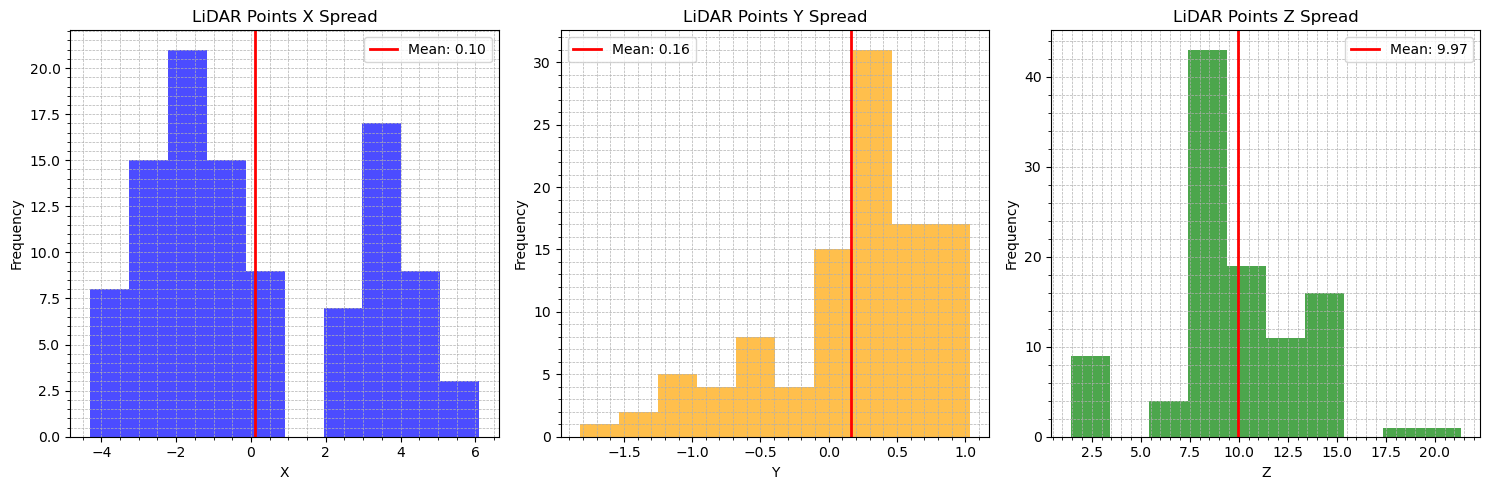

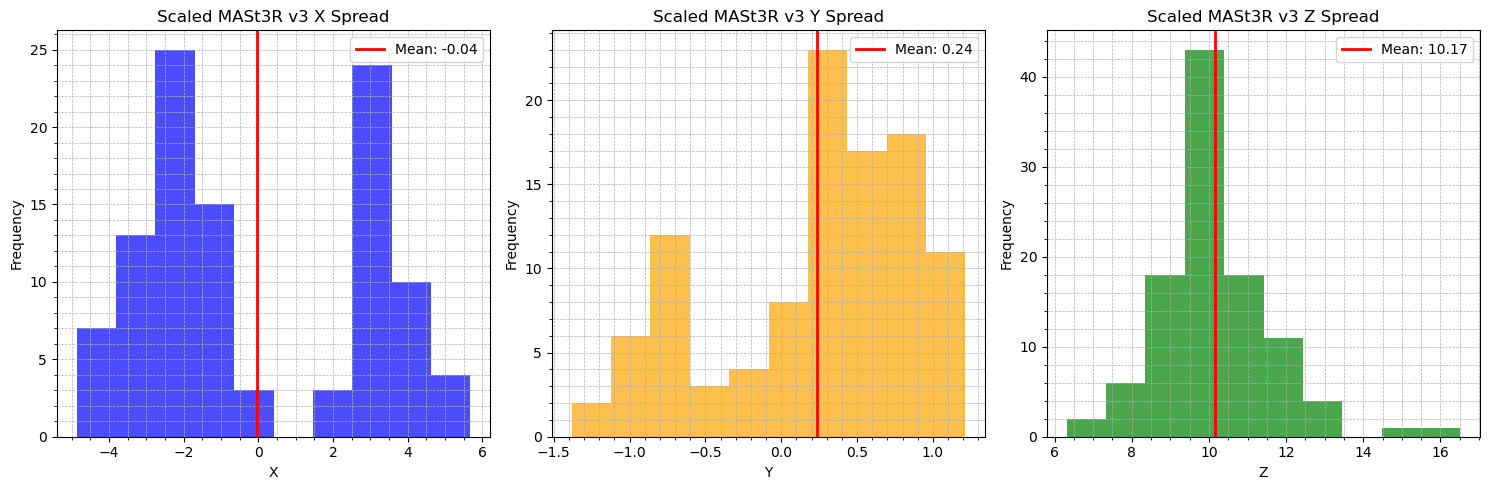

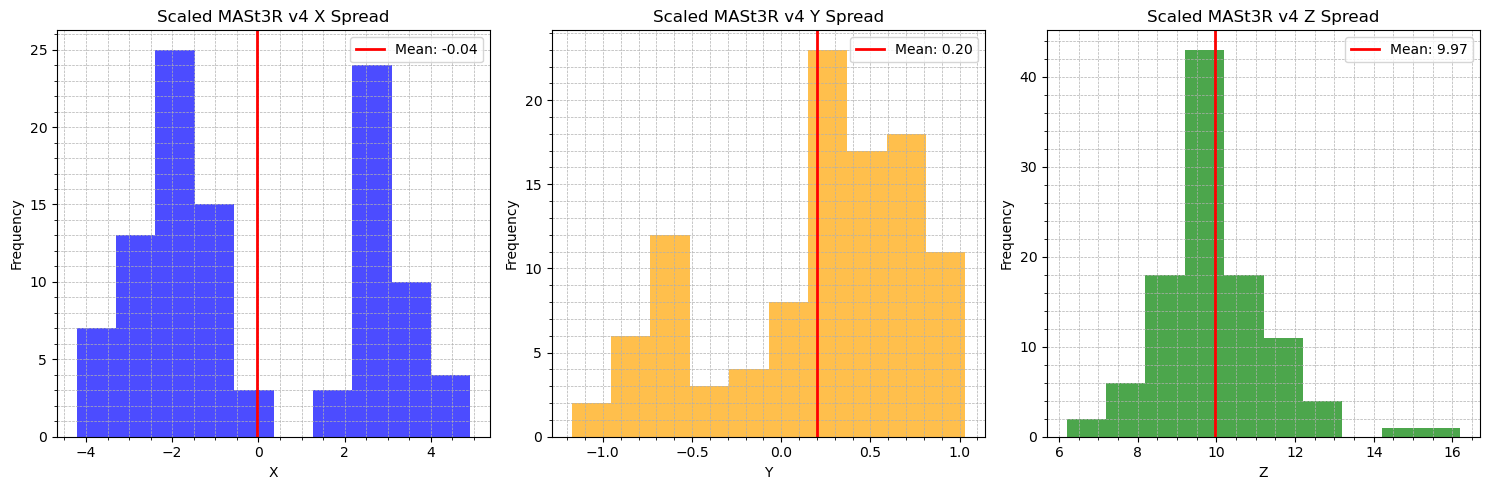

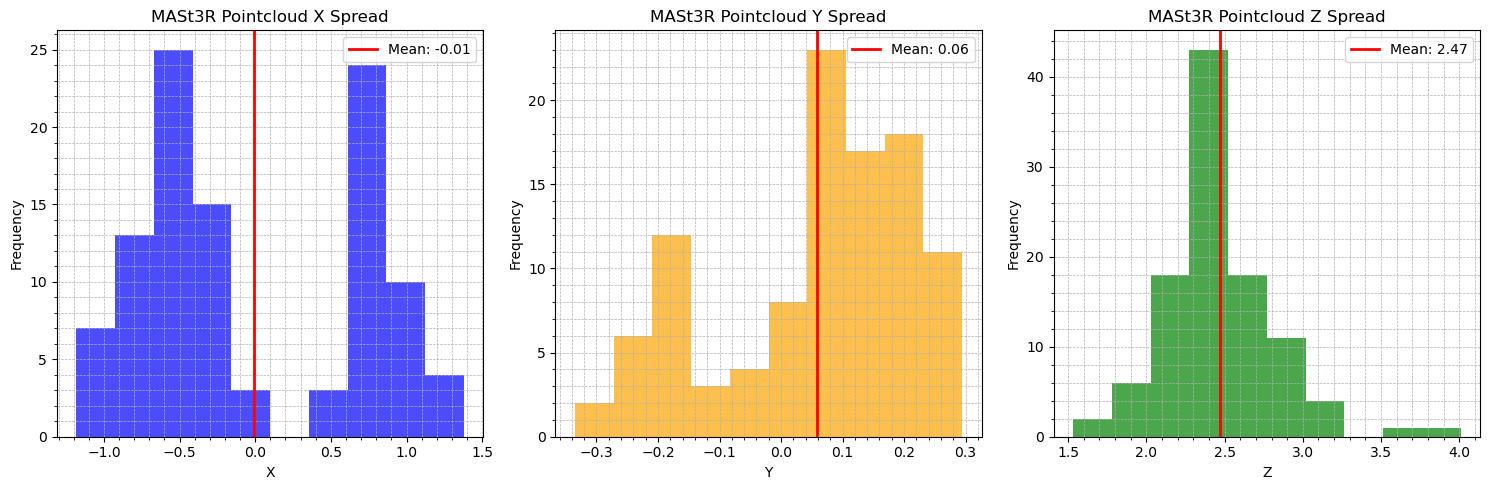

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(points, title_prefix):
    """
    Plot histograms for the spread of x, y, z points in a point cloud,
    with a vertical line indicating the mean.
    Args:
        points: (N, 3) array of point cloud coordinates.
        title_prefix: Prefix for the histogram titles.
    """
    if points.size > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (label, color) in enumerate(zip(['X', 'Y', 'Z'], ['blue', 'orange', 'green'])):
            ax = axes[i]
            ax.hist(points[:, i], bins=10, color=color, alpha=0.7)
            ax.set_title(f'{title_prefix} {label} Spread')
            ax.set_xlabel(label)
            ax.set_ylabel('Frequency')
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.minorticks_on()

            # Add vertical line for the mean
            mean_value = np.mean(points[:, i])
            ax.axvline(mean_value, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_value:.2f}')
            ax.legend()

        plt.tight_layout()
        plt.show()
    else:
        print(f"No points available for {title_prefix}.")

# Plot histograms for each scaled point cloud
plot_histograms(lidar_pts, "LiDAR Points")
plot_histograms(mast3r_pts_scaled_v3, "Scaled MASt3R v3")
plot_histograms(mast3r_pts_scaled_v4, "Scaled MASt3R v4")
plot_histograms(mast3r_pts, "MASt3R Pointcloud")

In [11]:
print(len(inlier_im0))
print(len(matched_indices))

104
104


In [12]:
print(lidar_pts)


[[-2.16704193 -1.27804972 14.25360923]
 [-2.33116049 -1.2756603  14.15912702]
 [-3.64804975 -1.8193148  21.31438472]
 [-2.30858229 -1.11145872 14.15463495]
 [-2.30858229 -1.11145872 14.15463495]
 [-2.30858229 -1.11145872 14.15463495]
 [-2.01521463 -1.13903804 15.20500443]
 [-1.89433089 -1.13343336 15.02650658]
 [-1.09939097 -0.62080511  8.86661574]
 [ 0.054812   -0.10598035  1.44513578]
 [ 0.07374771 -0.10706512  1.44444961]
 [-0.46289404 -0.95362514 14.84331197]
 [-2.29303665 -0.94800134 14.17513759]
 [-2.0507246  -0.94992396 14.34763363]
 [-0.46289404 -0.95362514 14.84331197]
 [-1.30597637 -0.51857037  8.84399312]
 [-1.07572365 -0.51985168  8.80493768]
 [-0.96869275 -0.51942226  8.83521084]
 [-0.80799575 -0.51862083  8.88564253]
 [-0.69456709 -0.51916405  8.86494667]
 [-0.32962551 -0.42720122  8.52785314]
 [-1.17495364 -0.4165372   8.79888271]
 [-0.04053931 -0.04779534  1.51095551]
 [-0.79913311 -0.19541976  8.65736375]
 [-0.67332702 -0.20550788  8.49366413]
 [-0.91705332 -0.19069891